# Vietnam Boundary Comparison

In [9]:
import sys, os, importlib, json, multiprocessing
import folium, shapely, rasterio

import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Polygon, Point, mapping
from shapely.ops import unary_union
from urllib.request import urlopen

sys.path.insert(0, "../../gostrocks/src/")
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.rasterMisc as rMisc

sys.path.append("../src")
from GOSTboundaries import boundary_helper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
geobounds_url = 'https://www.geoboundaries.org/api/current/gbOpen/{iso3}/ADM{lvl}/'
sel_iso3 = 'VNM'
h3_lvl = 6
official_wb_bounds = f"/home/wb411133/projects/BOUNDARIES/Data/WB_med_res/{sel_iso3}_medium_res.geojson"
high_res_bounds = '/home/wb411133/projects/BOUNDARIES/Data/HighRes/WB_GAD_ADM_Samples/shp/WB_GAD_ADM2.shp'
output_folder = "/home/wb411133/projects/BOUNDARIES/"
html_maps_folder = "/home/wb411133/Code/Boundary_Comparison/docs/_static"
# Open official World Bank boundaries
selWB = gpd.read_file(official_wb_bounds)

inH = gpd.read_file(high_res_bounds)
selWB = selWB.to_crs(4326)
selH = inH.loc[inH['ISO_A3'] == sel_iso3]

comparer = boundary_helper.country_boundary(sel_iso3, selWB, "OBJECTID", geoBounds=selH)
comparer.run_all(run_h3_summary=True, run_comparison=False, run_zonal=True)

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
Matching bounds2 to bounds 1:   0%|          | 0/681 [00:00<?, ?it/s]/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
Matching h3 to bounds 2: 100%|██████████| 8144/8144 [03:16<00:00, 41.53it/s]


## Comparing Boundaries
There are substantive differences between the medium-resolution boundaries and the high-resolution boundaries; these areas are most prevalent in coastal islands and small, urban administrative units.

In [11]:
# Hanoi
comparer.map_boundary_comparison(Point(105.81492,21.02619), 12)

In [12]:
# Tra Ban Islands
comparer.map_boundary_comparison(Point(107.19508,20.88403), 11, buffer_dist=0.2)

This leads to variation in certain zonal statistics in these areas. In this experiment we ran the following comparisons:
1. [ESA Globcover](http://due.esrin.esa.int/page_globcover.php) - determine the majority landcover class in each district
2. [Nighttime Lights](https://registry.opendata.aws/wb-light-every-night/) - calculate sum of lights for most recent month (2023-02)
3. [H3 grid comparison](https://geographicdata.science/book/data/h3_grid/build_sd_h3_grid.html) - joined h3 grid cells to admin divisions and identified which h3 grid cells join the different administrative divisions based on resolution.

## ESA Globcover
This ~300m2 resolution landcover dataset classifies landcover into [23 categories](https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2008/03/globcover_legend/9738784-3-eng-GB/GlobCover_legend_pillars.jpg).

For each admin division we calculated the majority class and compared between the medium and high resolution datasets

Of the 681 admin 2 divisions in Vietnam, 12 have a different majority landcover class.

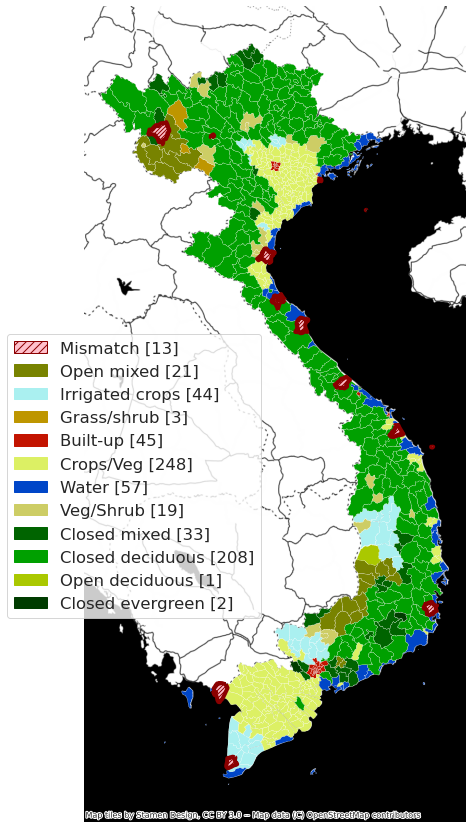

In [18]:
cur_plot = comparer.static_map_lc(legend_loc=[-0.2,0.25])
cur_plot

## Nighttime Lights
We calculated sum of lights for each dataset, and then compared them, as % change from medium-resolution boundary to high-resolution.


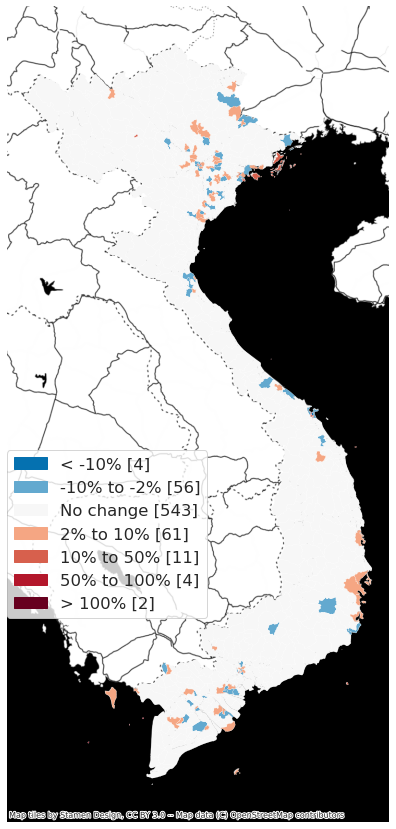

In [14]:
ntl_summary = comparer.ntl_summary(legend_loc=[0,0.25])
ntl_summary[0]

In [15]:
ntl_summary[1]

Number of districts with NTL change (medium to high)
< -10%           4
-10% to -2%     56
No change      543
2% to 10%       61
10% to 50%      11
50% to 100%      4
> 100%           2
Name: OBJECTID, dtype: int64

## H3 grid comparison
Using h3 grid level 6 ([~36km2](https://h3geo.org/docs/core-library/restable/)), there are 8144 individual h3 grid cells in Vietnam. Of those, 46 are identified as having different parental admin boundaries based on resolutions


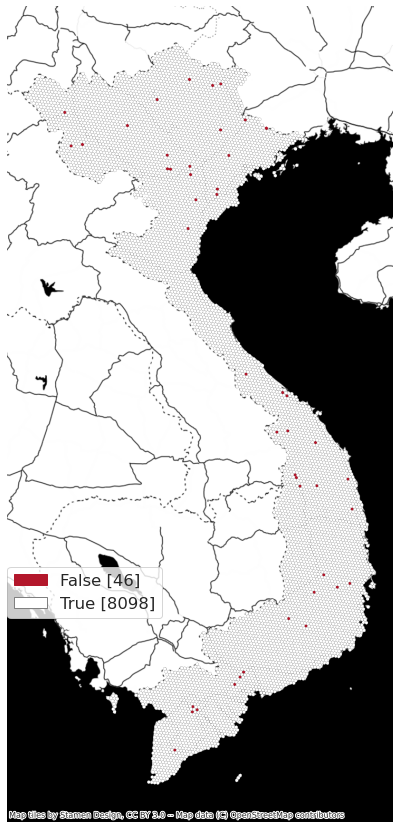

In [16]:
mapp = comparer.static_map_h3(legend_loc=[0,0.25])